# 1.-LEctura de datos

In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [4]:
%reset -f

In [7]:
file_path = '/content/rama_2023_05_missing_outliers_limited.csv'
df = pd.read_csv(file_path)

In [8]:
# Mostrar las primeras filas del DataFrame
print("Primeras filas del DataFrame:")
print(df.head())


Primeras filas del DataFrame:
        fecha        CO         NO        NO2        NOX         O3  \
0  2015-01-01  1.050696  22.765528  24.225155  46.987578  23.175150   
1  2015-01-02  0.807585  32.249608  21.554160  53.800628  17.268366   
2  2015-01-03  0.640755  21.686916  19.394081  41.071651  15.486486   
3  2015-01-04  0.726940  24.606272  19.560976        NaN  17.329032   
4  2015-01-05  0.530815  11.443182  20.990260  32.439935  14.470588   

         PM10       PM25        SO2  
0  105.573684  78.953405  11.554723  
1   36.687845  15.449438        NaN  
2   29.269022  12.915129   1.436937  
3   39.961538  16.838284   1.809061  
4   31.855643        NaN   8.315789  


In [9]:
# Reemplazar valores -99 con NaN
df.replace(-99, np.nan, inplace=True)

In [10]:
# Convertir la columna 'fecha' a formato datetime y establecerla como índice
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y-%m-%d', errors='coerce')
df.set_index('fecha', inplace=True)



In [11]:
# Verificar y mostrar fechas no convertidas
invalid_dates = df[df.index.isna()]
if not invalid_dates.empty:
    print("Fechas no convertidas correctamente:")
    print(invalid_dates)

In [12]:
# Mostrar estadísticas descriptivas redondeadas del DataFrame
print("Estadísticas descriptivas del DataFrame:")
print(df.describe().round())

Estadísticas descriptivas del DataFrame:
           CO      NO     NO2     NOX      O3    PM10    PM25     SO2
count  2916.0  2918.0  2916.0  2931.0  2916.0  2931.0  2928.0  2936.0
mean      1.0    17.0    23.0    38.0    30.0    47.0    24.0     4.0
std       2.0    52.0     7.0    15.0     9.0   129.0    62.0    14.0
min       0.0     1.0     8.0    10.0     3.0     8.0     3.0     1.0
25%       0.0     8.0    18.0    27.0    24.0    30.0    15.0     2.0
50%       0.0    13.0    22.0    36.0    30.0    40.0    21.0     3.0
75%       1.0    19.0    27.0    47.0    36.0    53.0    26.0     4.0
max      43.0  1423.0    72.0   148.0    67.0  4055.0  1869.0   355.0


## Grafico de variables

In [13]:
variables = ['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM25', 'SO2']

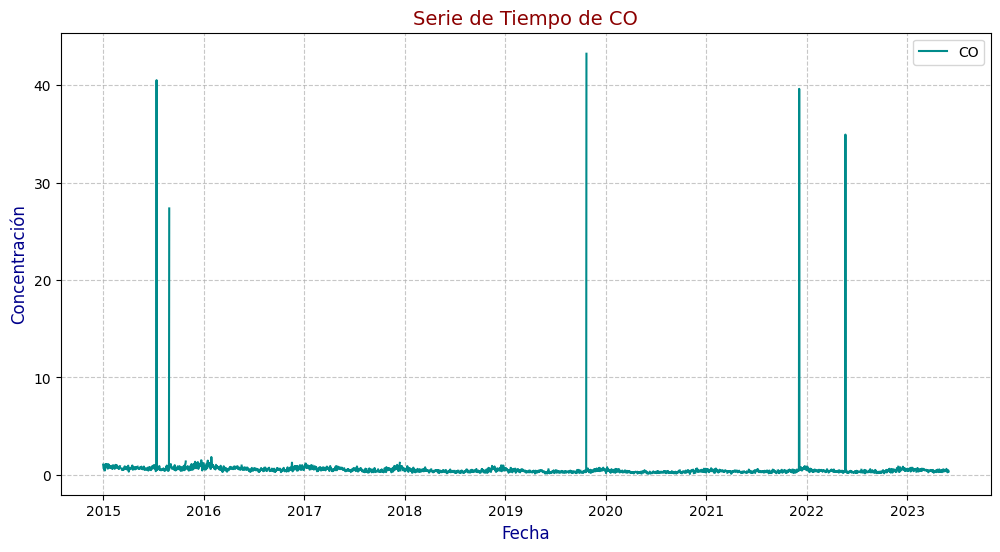

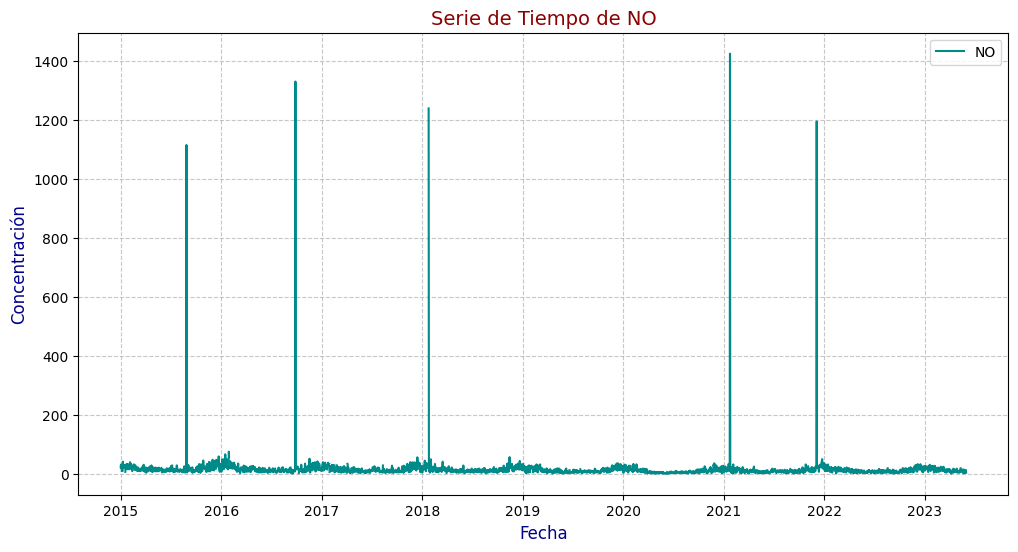

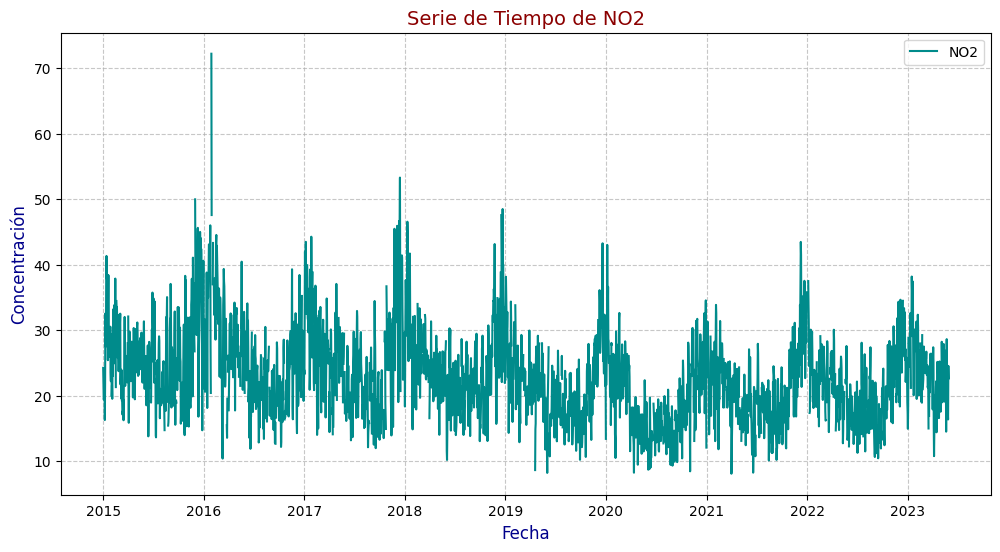

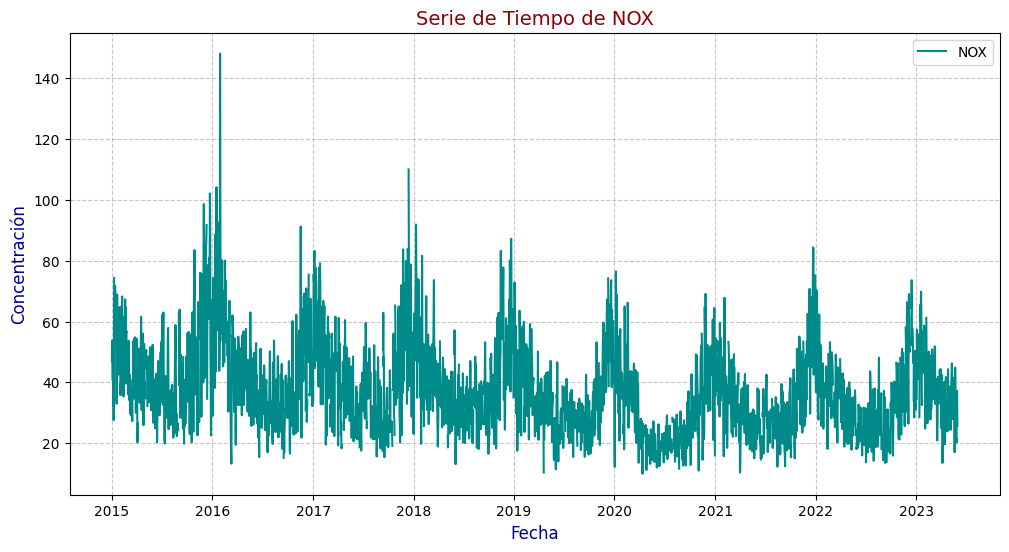

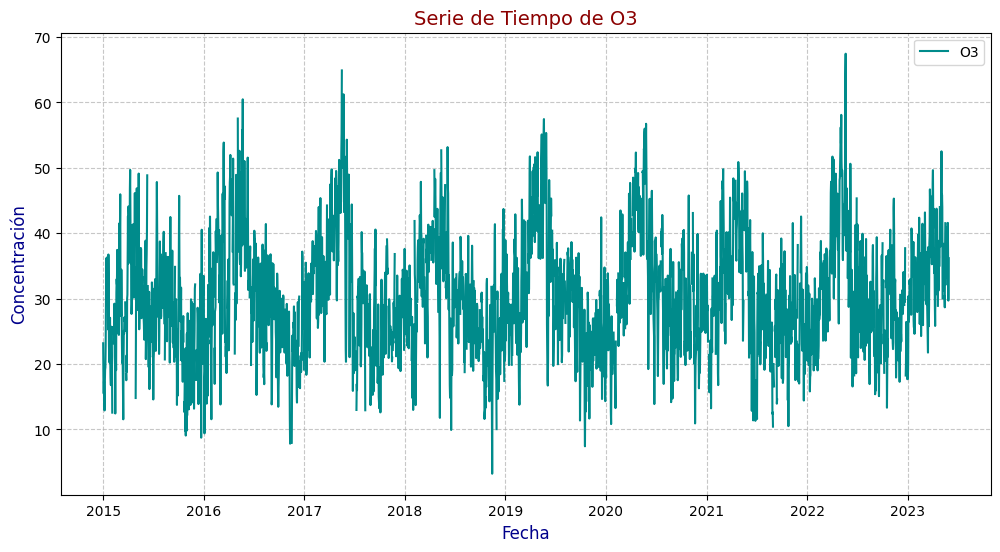

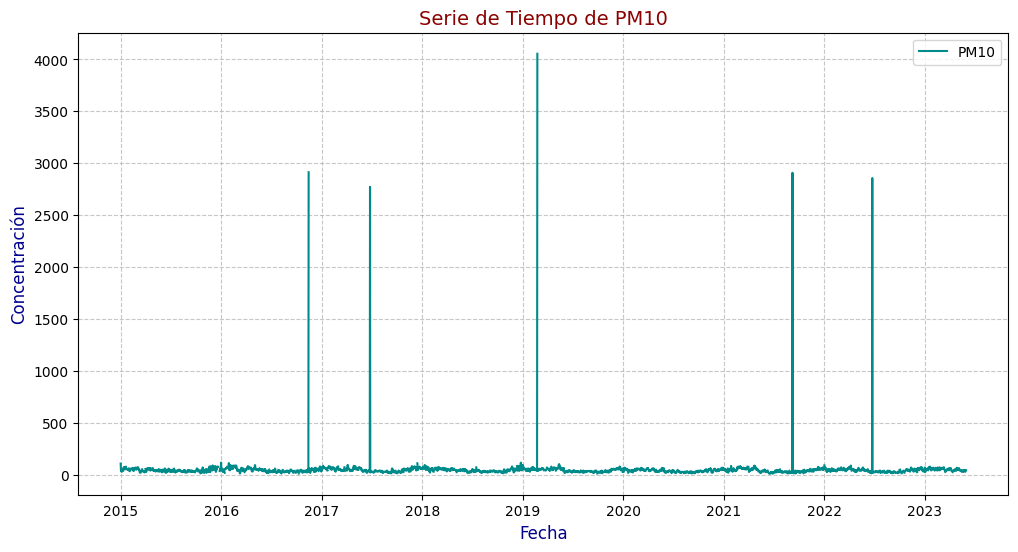

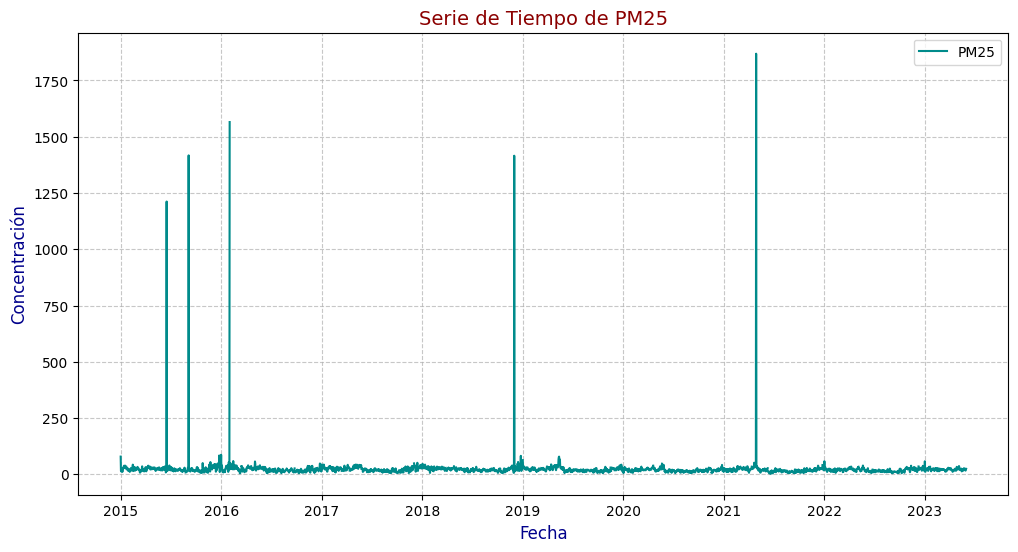

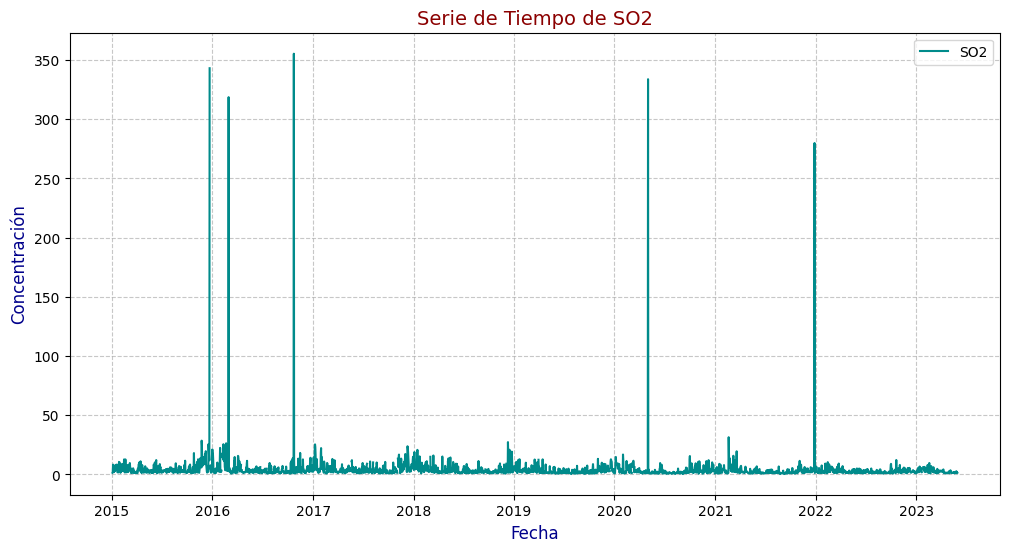

In [14]:
# Verificar si todas las variables existen en el DataFrame
missing_variables = [var for var in variables if var not in df.columns]
if missing_variables:
    print(f"Las siguientes variables no están en el DataFrame: {missing_variables}")
else:
    # Graficar cada variable en una serie de tiempo
    for variable in variables:
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df[variable], color='darkcyan', label=variable)
        plt.xlabel('Fecha', fontsize=12, color='darkblue')
        plt.ylabel('Concentración', fontsize=12, color='darkblue')
        plt.title(f'Serie de Tiempo de {variable}', fontsize=14, color='darkred')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc='upper right')
        plt.show()

## Identificacion y manejo de valores atipicos

In [15]:
# Seleccionar solo columnas numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_columns]

In [16]:
# Calcular el umbral para identificar outliers (3 desviaciones estándar)
threshold = 3 * df_numeric.std()

In [17]:
# Identificar y sustituir los valores atípicos por np.nan
outliers = (np.abs(df_numeric - df_numeric.mean()) > threshold)
df_numeric[outliers] = np.nan

In [18]:
# Imputar valores nulos utilizando interpolación lineal
df_imputed = df_numeric.interpolate(method='linear')


In [19]:
# Mostrar la suma de valores nulos para verificar que se hayan imputado correctamente
print("Valores nulos después de la imputación:")
print(df_imputed.isnull().sum())

Valores nulos después de la imputación:
CO      0
NO      0
NO2     0
NOX     0
O3      0
PM10    0
PM25    0
SO2     0
dtype: int64


## Analisis de las series de tiempo

In [20]:
print("Estadísticas descriptivas después de la imputación:")
print(df_imputed.describe().round())

Estadísticas descriptivas después de la imputación:
           CO      NO     NO2     NOX      O3    PM10    PM25     SO2
count  3073.0  3073.0  3073.0  3073.0  3073.0  3073.0  3073.0  3073.0
mean      0.0    15.0    23.0    38.0    30.0    42.0    21.0     4.0
std       0.0     9.0     6.0    14.0     9.0    16.0     9.0     3.0
min       0.0     1.0     8.0    10.0     7.0     8.0     3.0     1.0
25%       0.0     8.0    18.0    27.0    24.0    30.0    15.0     2.0
50%       0.0    13.0    22.0    36.0    30.0    40.0    21.0     3.0
75%       1.0    19.0    27.0    47.0    36.0    53.0    26.0     4.0
max       2.0    76.0    43.0    82.0    57.0   115.0    87.0    31.0


## Modelado y prediccion

In [21]:
# Elegir la variable para la predicción
variable = 'PM25'  # Puedes cambiar esta variable según lo necesario
data_variable = df_imputed[[variable]].dropna()


In [22]:
# Escalado de datos
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_variable)

In [23]:
# Preparación de datos para RNN
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X, y = create_dataset(data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)


In [24]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)),
    SimpleRNN(50),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# Entrenamiento del modelo
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0414 - val_loss: 0.0061
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [27]:
# Predicción
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [28]:
# Invertir la escala de los datos
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

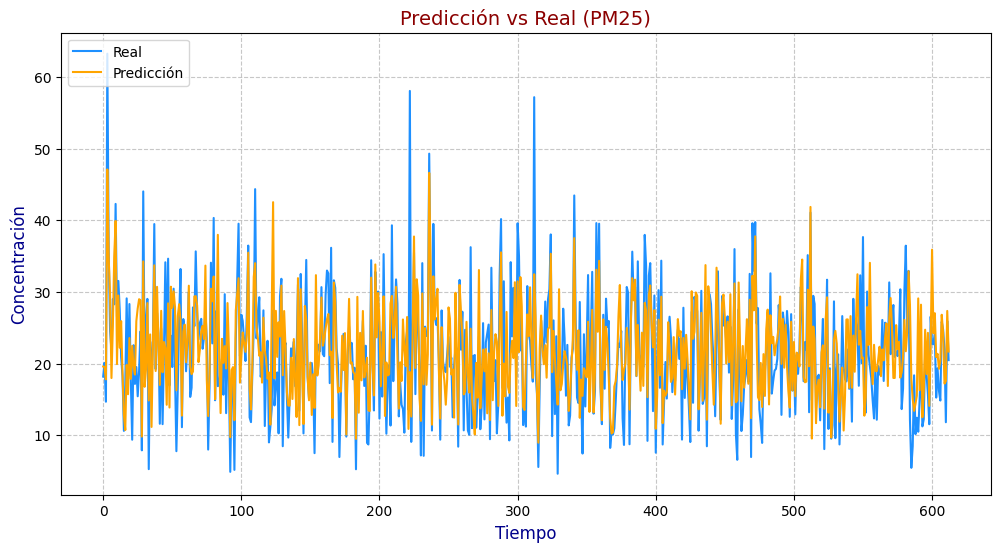

In [29]:
# Visualización de resultados
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Real', color='dodgerblue')
plt.plot(test_predict, label='Predicción', color='orange')
plt.xlabel('Tiempo', fontsize=12, color='darkblue')
plt.ylabel('Concentración', fontsize=12, color='darkblue')
plt.title('Predicción vs Real (PM25)', fontsize=14, color='darkred')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()